In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pymc
import xarray as xr
import arviz as az

# 1. Bayesian Coin Toss

### Setup 
Let's generate 500 coin tosses from a [Bernoulli distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html?highlight=bernoulli#scipy.stats.bernoulli):

In [2]:
p = 0.5
n_draws = 1000
data = stats.bernoulli.rvs(p, size=n_draws)

### Explore the data
Explore the data by calculating its [empirical mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) and its [empirical  variance](https://numpy.org/doc/stable/reference/generated/numpy.var.html). Look up, how mean and variance of a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) are defined. What do you notice?

In [3]:
np.mean(data), np.var(data)

(0.504, 0.24998400000000004)

In [4]:
p, p * (1 - p)

(0.5, 0.25)

### Code a plot function
Fill out the function `plot_coin_toss` that computes the *posterior distribution* given a number of coin tosses as *data*. By choosing a suitable likelihood-prior pair and doing some fancy math, we know that the posterior is a *beta distribution* with $a = 1 + n_\text{heads}, \, b = 1 + n_\text{trials} - n_\text{heads}$.

- Take the first $n_\text{trials}$ draws from data and compute the number of heads.

- Use the PDF (probability density function) of the [beta distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html#scipy.stats.beta), to compute the posterior distribution for every point in `x`.

In [5]:
def plot_coin_toss(n_trials, data):
    n_heads = data[:n_trials].sum()

    x = np.linspace(0, 1, 1000)
    posterior_pdf = stats.beta.pdf(x, 1 + n_heads, 1 + n_trials - n_heads)
    
    plt.title("%s trials, %s heads" % (n_trials, n_heads))
    plt.xlabel("$P(H)$, Probability of Heads")
    plt.ylabel("Density")
    plt.plot(x, posterior_pdf, label="observe %d tosses,\n %d heads" % (n_trials, n_heads))
    plt.fill_between(x, 0, posterior_pdf, color="#aaaadd", alpha=0.5)
    plt.xlim((0., 1.))
    plt.ylim((0., 30.))
    plt.show()

### Run multiple trials
Execute the coin toss function for multiple number of trials (e.g. 0, 2, 10, 20, 50, 500). Is the result sensible? Describe what you see and what this means for the estimation.

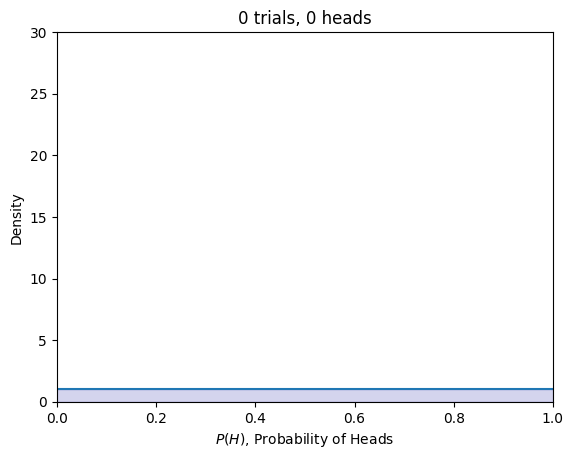

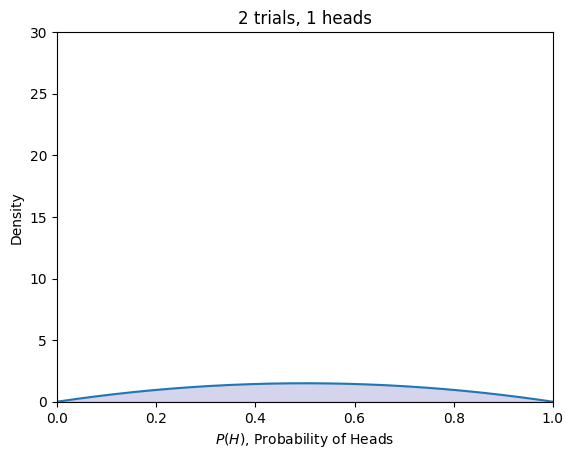

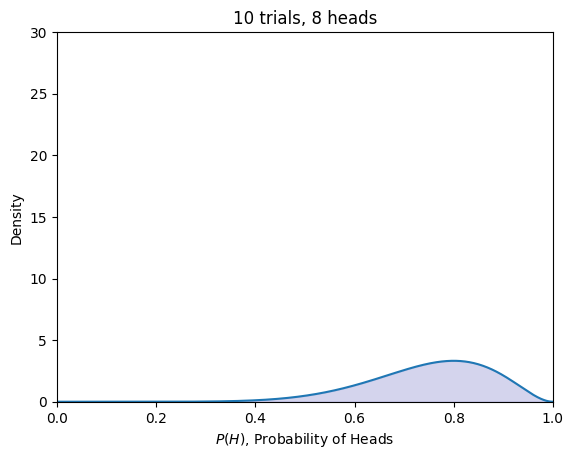

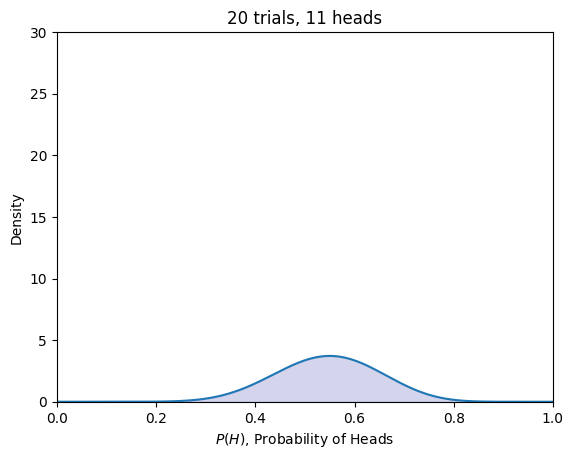

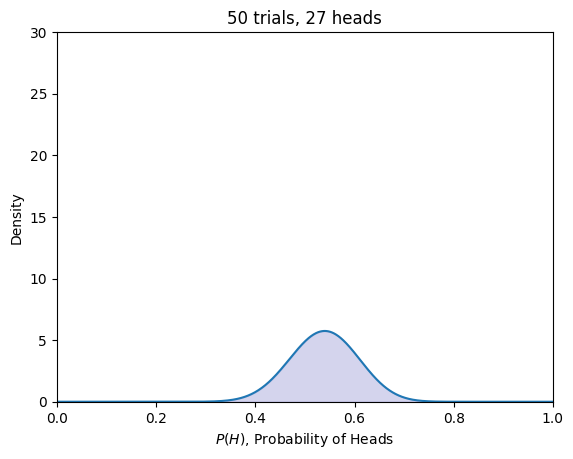

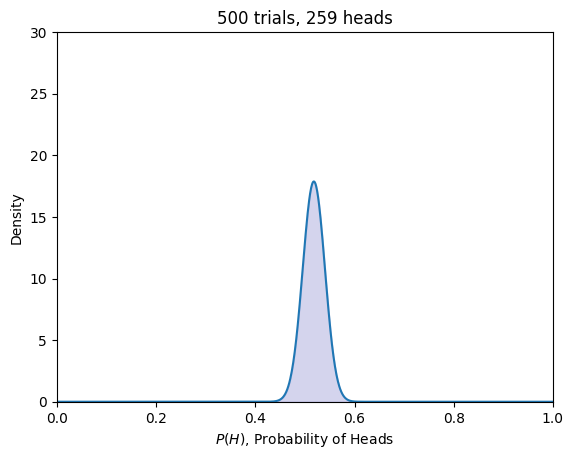

In [6]:
for n in [0, 2, 10, 20, 50, 500]:
    plot_coin_toss(n, data)

### (Optional) Animate coin toss
Use [Jupyter Widgets](https://ipywidgets.readthedocs.io/en/latest/) to build an jupyter notebook application with two sliders that modify $p$ and $n_\text{trials}$. Set $n_\text{draws}$ to a higher value. Have fun!

In [7]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt, random

def interactive_plot(n_trials, p):
    data = stats.bernoulli.rvs(p, size=2000)
    plot_coin_toss(n_trials, data)
    return
interact(interactive_plot, n_trials=(1,2000, 10), p=(0., 1., 0.05));

interactive(children=(IntSlider(value=991, description='n_trials', max=2000, min=1, step=10), FloatSlider(valu…

# 2. Michaelis Menten: A small Bayesian Analysis

The [Michaelis-Menten kinetics](https://en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics) is the simplest model of a enzyme-catalyzed reaction. It maps the substrate concentration $c$ to the reaction rate $v$ by
$$ v(c) = v_\text{max} \cdot \frac{c}{K_m + c}$$
$v_\text{max}$ and $K_m$ are enzyme-specific parameters, both constrained to $(0, \infty)$. We will use the Michaelis-Menten model to infer these parameters from generated reaction rates.

### Setup

Execute the cell below to generate the data for this exercise.

In [8]:
def michaelis_menten(v_max, k_m, c):
    return v_max * c / (k_m + c)

v_max = 1.
k_m = 0.1

n = 10
sigma = 1e-1
c = np.power(10, np.linspace(-3, 1, num=n))
v = michaelis_menten(v_max, k_m, c) + np.random.normal(loc=0, scale=sigma)

### Explore the data

- Plot substrate data `c` against the "measured" reaction rates `v`. Explain what is going on in terms of substrate concentration and enzyme activity.
- Try using different values for `v_max` and `k_m`. Explain how they effect the generated data.

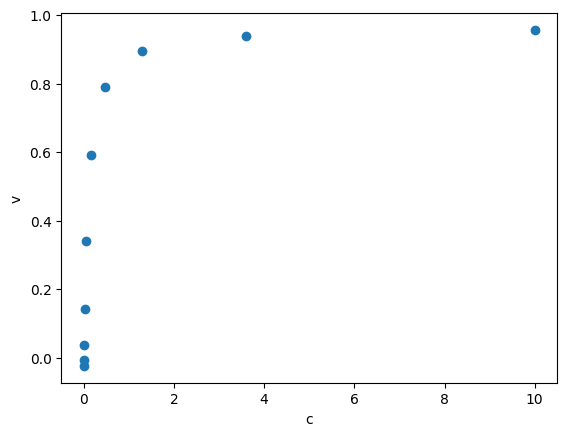

In [9]:
plt.scatter(c, v)
plt.xlabel("c")
plt.ylabel("v")
plt.show()

### Select appropriate priors

Experiment to find suitable priors. Remember, that both parameters have lower bounds which needs to be reflected in the choice of prior. Execute the prior predictive check below. Because you don't have any particular knowledge, avoid too informative priors. You can assume, however, that you are sure about magnitude of the measurement values.

You will now start to use `pymc`, a software for Bayesian Inference, and MCMC. In `pymc`, model variables are specified by their prior, e.g. 
`var_name = pymc.Normal("variable name", 0, 1)`.

Some inspiration:
- [Half normal](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.HalfNormal.html) (prefers close to zero values) or [Log normal](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.LogNormal.html) distributions (probablity mass peak can be shifted)
- [Bound transformation](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.distributions.transforms.Interval.html#pymc.distributions.transforms.Interval) for any [continuous distribution](https://www.pymc.io/projects/docs/en/latest/api/distributions/continuous.html)
- [Half flat](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.HalfFlat.html) distribution (least informative choice, but is improper and you can't do prior predictive checks)

In [10]:
with pymc.Model() as model:
    # Priors
    v_max_rv = pymc.LogNormal("v_max", 0, 0.25)
    k_m_rv = pymc.LogNormal("k_m", 0, 1)
    
    # Likelihood
    v_rv = michaelis_menten(v_max_rv, k_m_rv, c)
    pymc.Normal("obs", mu=v_rv, sigma=sigma, observed=v)

In [11]:
with model:
    trace = pymc.sample_prior_predictive(samples=100)

Sampling: [k_m, obs, v_max]


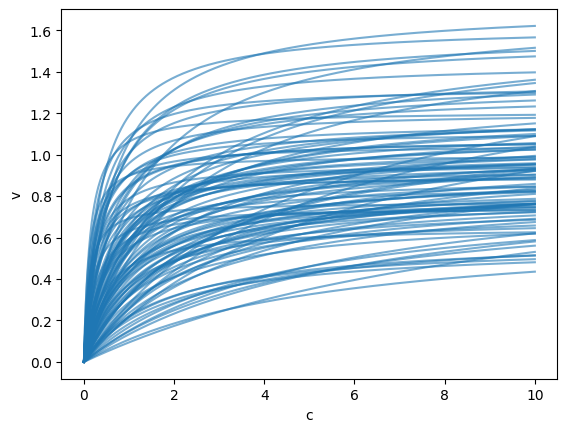

In [12]:
c_pred = xr.DataArray(np.linspace(1e-3, 10, num=1000))
v_pred = michaelis_menten(trace.prior["v_max"], 
                          trace.prior["k_m"],
                          c_pred)

plt.plot(c_pred, v_pred.stack(sample=("chain", "draw")), color="tab:blue", alpha=0.6)
plt.xlabel("c")
plt.ylabel("v")
plt.show()

### Obtaining the posterior: MCMC sampling

The next step is infering the posterior by MCMC. This can be easily done by `pymc` with the `pymc.sample` command. Look at the posterior plot. Are the results sensible?

In [13]:
with model:
    trace = pymc.sample(500, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [v_max, k_m]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 8 seconds.


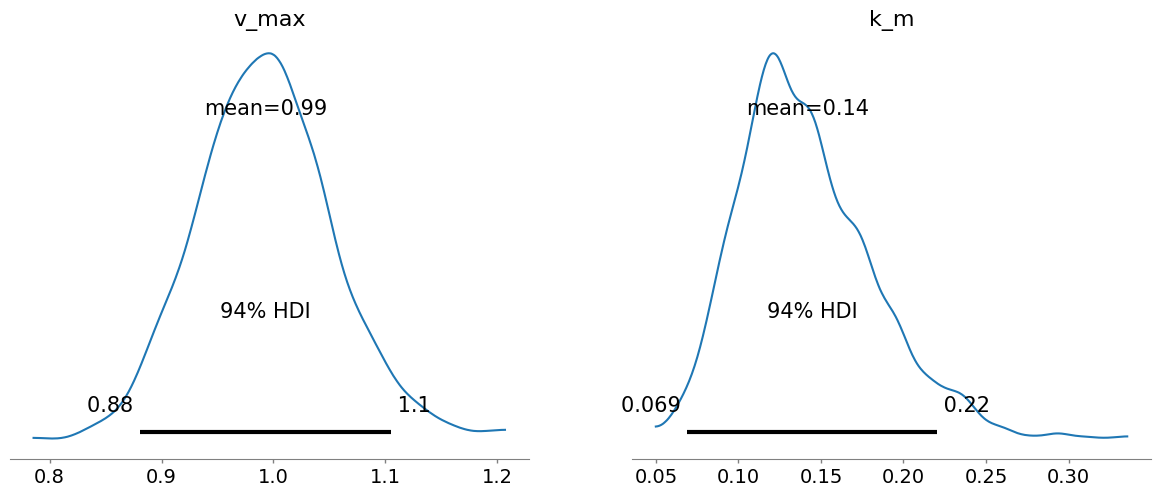

In [14]:
pymc.plot_posterior(trace)
plt.show()

### Posterior Predictive Checks

Posterior predictive checks can also be done easily by `pymc`. Run the code below code. Would you accept the results of the analysis?

In [15]:
with model:
    pymc.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [obs]


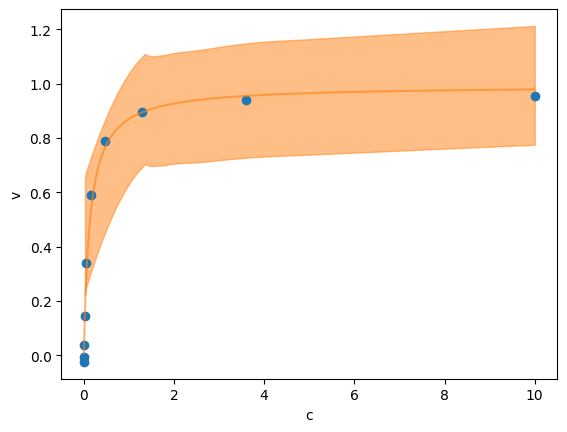

In [16]:
c_pred = xr.DataArray(np.linspace(1e-3, 10, num=1000))
v_pred = michaelis_menten(trace.posterior["v_max"], 
                          trace.posterior["k_m"],
                          c_pred)

plt.plot(c_pred, v_pred.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6)
az.plot_hdi(c, trace.posterior_predictive["obs"])
plt.scatter(c, trace.observed_data["obs"])
plt.xlabel("c")
plt.ylabel("v")
plt.show()